# 1

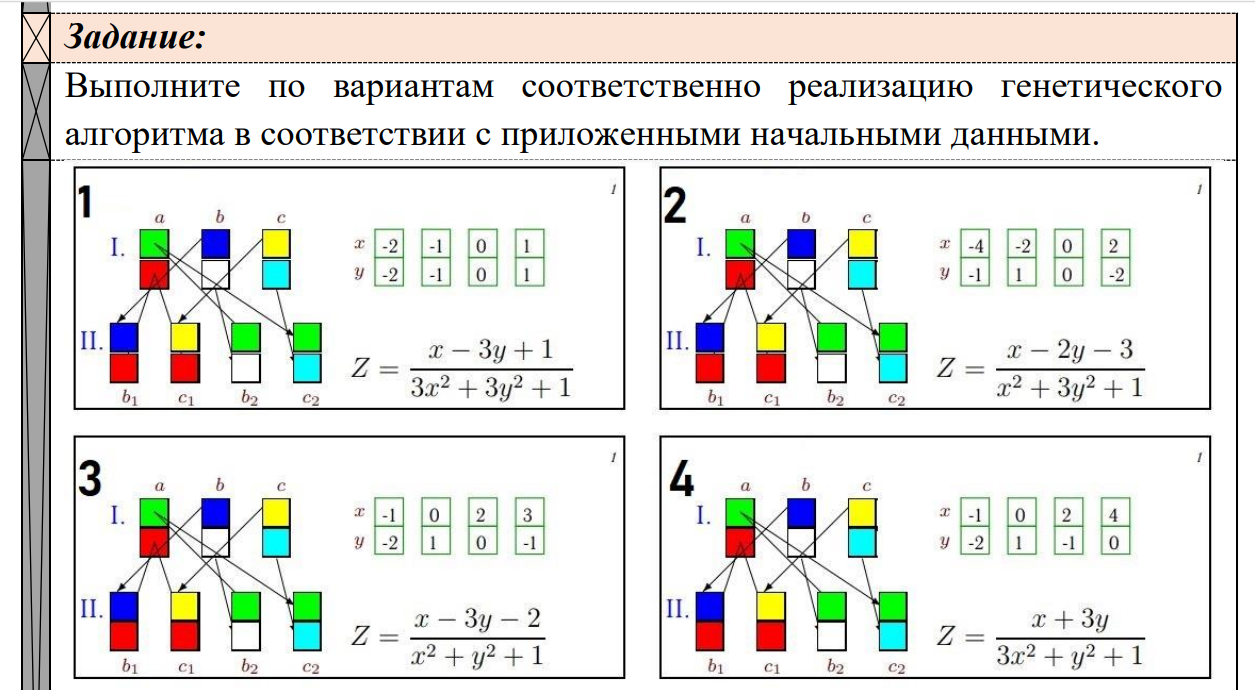

In [1]:
# качество хромосомы
def qZ(x, y):
    return (x - 3 * y + 1) / (3 * x ** 2 + 3 * y ** 2 + 1)


# суммарное качество хромосом
def qSumZ(Z):
    return sum(Z)


# обмен хромосомами
def exchangeScheme(oldX, oldY, sortedId):
    x = [0 for i in range(4)]
    y = [0 for i in range(4)]

    x[2] = oldX[sortedId[2]]
    x[3] = oldX[sortedId[2]]

    x[0] = oldX[sortedId[0]]

    x[1] = oldX[sortedId[1]]

    y[0] = oldY[sortedId[2]]
    y[1] = oldY[sortedId[2]]

    y[2] = oldY[sortedId[0]]

    y[3] = oldY[sortedId[1]]

    return x, y


def sorting(Z):
    sortedId = sorted(range(len(Z)), key=lambda k: Z[k])
    return sortedId


#шаг эволюции
def evoStep(x, y, z):
    _, minId = min((value, id) for (id, value) in enumerate(z))
    x = x[:]
    y = y[:]
    z = z[:]

    x.pop(minId)
    y.pop(minId)
    z.pop(minId)

    return x, y, z


# шаги эволюции (конечная функция)
def evoSteps(x, y, steps_num=4):
    results = []

    for i in range(steps_num):
        arrZ = [qZ(k, y[i]) for i, k in enumerate(x)]

        x, y, z = evoStep(x, y, arrZ)

        x, y = exchangeScheme(x, y, sorting(z))

        results.append([x, y, qSumZ(arrZ), arrZ])

    return x, y, results


# данные наборы хромосом
x = [-2, -1, 0, 1]
y = [-2, -1, 0, 1]

results = evoSteps(x, y)

for i in range(len(results[2])):
    print(f'max_{i + 1}_step: {results[2][i][2]}')

qualityArrZ = []
for i in range(len(results[2])):
    qualityArrZ += results[2][i][3]

print(f'max Z: {max(qualityArrZ)}')

max_1_step: 1.4857142857142858
max_2_step: 1.4615384615384615
max_3_step: 2.967032967032967
max_4_step: 3.5384615384615383
max Z: 1.0


# 2

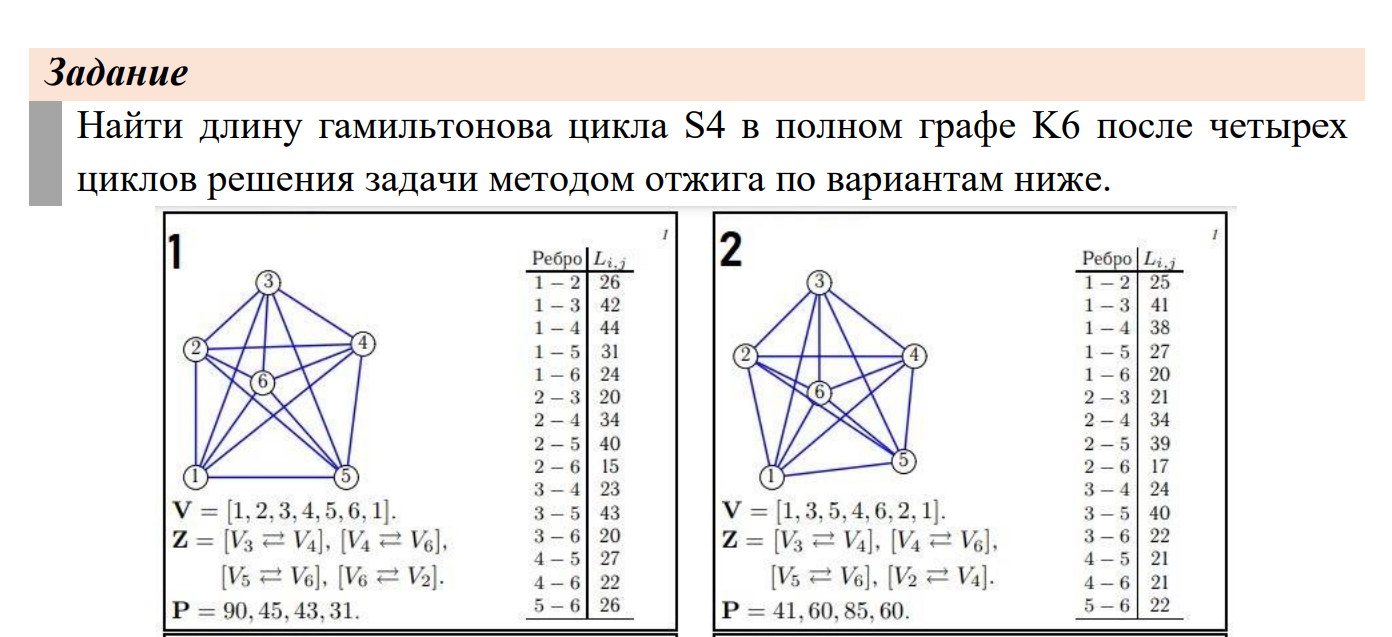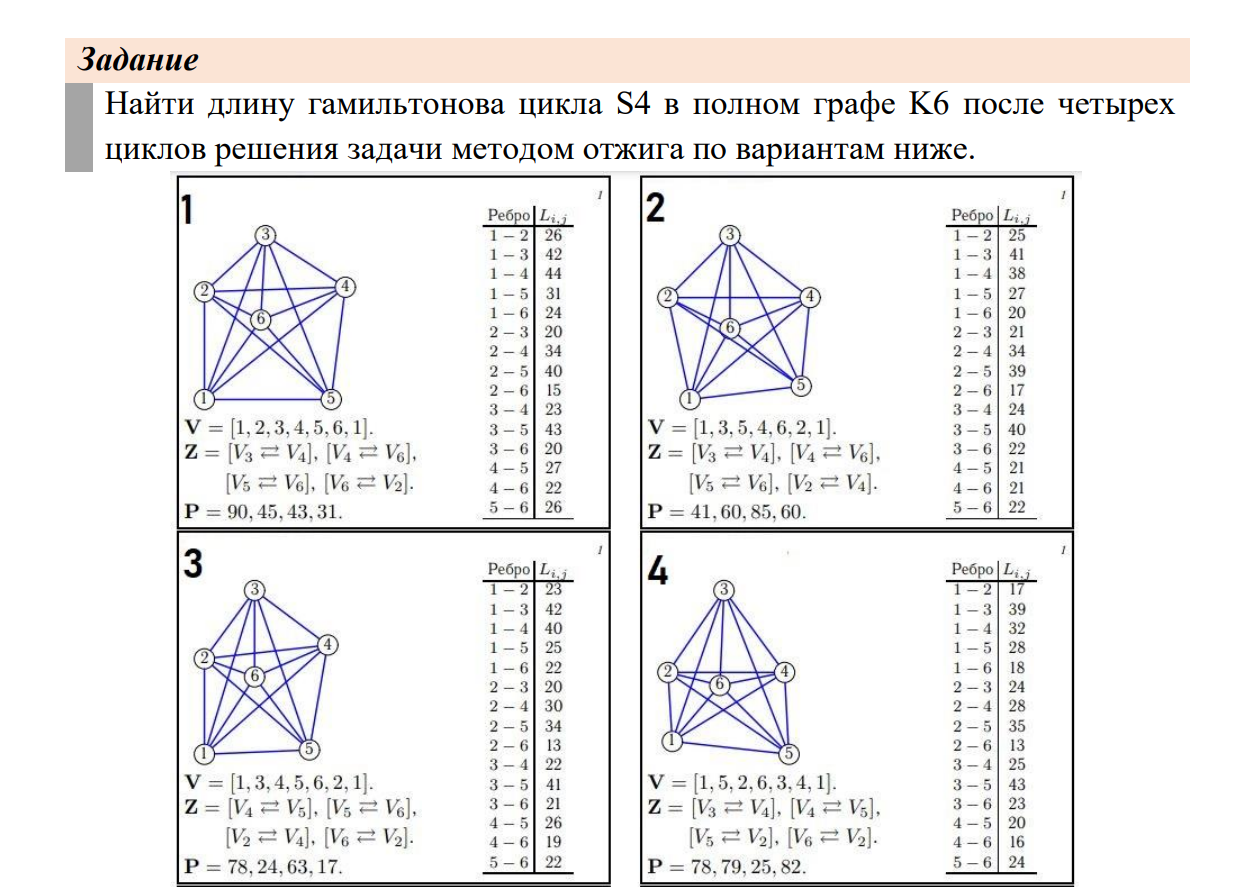

Лучший выбранный маршрут: [1, 5, 4, 3, 2, 6, 1]
Длина лучшего выбранного маршрута: 128
Длины всех рассмотренных маршрутов: [148, 162, 155, 142, 128]


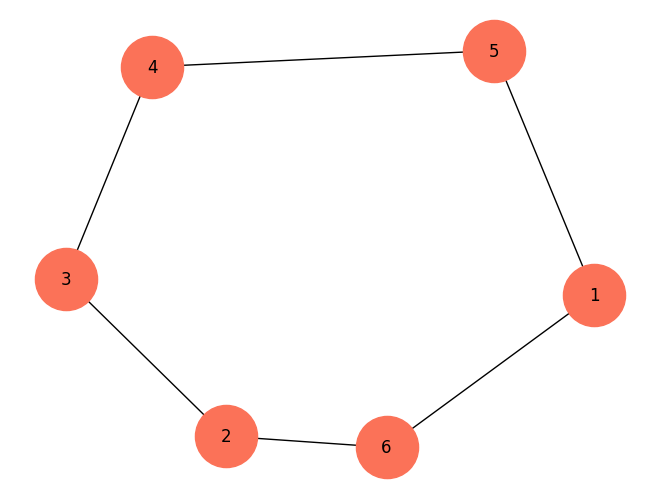

In [3]:
from math import e
import networkx as nx

distances = [(1, 2, 23),
            (1, 3, 42),
            (1, 4, 40),
            (1, 5, 25),
            (1, 6, 22),
            (2, 3, 20),
            (2, 4, 30),
            (2, 5, 34),
            (2, 6, 13),
            (3, 4, 22),
            (3, 5, 41),
            (3, 6, 21),
            (4, 5, 26),
            (4, 6, 19),
            (5, 6, 22)] # длины рёбер

V = [1, 3, 4, 5, 6, 2, 1] # последовательность прохождения маршрута
Z = [(4, 5),
    (5, 6),
    (2, 4),
    (6, 2)] # последовательность замен вершин
P = [78, 24, 63, 17] # случайные числа, выпавшие в процессе счёта

T = 100 # начальная температура

# функция вероятности
def probability(delta, T):
    return 100 * e ** (-delta / T)

# функция изменения температуры
def reductTemp(prevT):
    nextT = 0.5 * prevT
    return nextT

# вычисление длины ребра
def edgeLength(i, j, distances, roundTrip=True):
    if roundTrip:
        return max([(item[2] if (item[0] == i and item[1] == j) or (item[1] == i and item[0] == j) else -1)
                   for item in distances])
    else:
        return max([(item[2] if (item[0] == i and item[1] == j) else -1) for item in distances])

# вычисление длины маршрута
def routeLength(V, distances):
    edges = []

    for i in range(len(V) - 1):
        edges.append(edgeLength(V[i], V[i + 1], distances))

    return sum(edges)

# одна перестановка в пути
def routeOneReplacement(arrV, Z, replacementByName=True):
    decrement = 1 if replacementByName else 0

    arrV[Z[0] - decrement], arrV[Z[1] - decrement] = arrV[Z[1] - decrement], arrV[Z[0] - decrement]

    return arrV

# перестановка в пути
def routeReplacement(V, Z):
    for z in Z:
        V = routeOneReplacement(V, z)
    return V

# выбор нужного пути методом отжига
def chooseRoute(distances, V, Z, T, P):
    sumLength = routeLength(V, distances) # нахождение длины пути
    arrSum = [sumLength] # массив сумм длин

    # циклы методом отжига
    for i in range(len(Z)):
        newV = routeOneReplacement(V[:], Z[i]) # новый маршрут после перестановки
        newS = routeLength(newV, distances) # длина нового маршрута
        arrSum.append(newS)
        deltaS = newS - sumLength # разница длин нового и старого маршрутов

        # если новый путь длиннее
        if deltaS > 0:
            p = probability(deltaS, T) # считаем вероятность
            # если вероятность от 0 до р, новый маршрут выбирается
            if p > P[i]:
                V = newV
                sumLength = newS
        else:
            V = newV
            sumLength = newS

        T = reductTemp(T) # вычисление температуры

    return V, arrSum

# визуализация графа по заданному маршруту
def drawRouteGraph(distances, bestRoute):
    newDistances = []

    for i in range(len(bestRoute) - 1):
        for distance in distances:
            if distance[0] == bestRoute[i] and distance[1] == bestRoute[i + 1] or distance[1] == bestRoute[i] and distance[0] == bestRoute[i + 1]:
                newDistances.append(distance)

    graph = nx.Graph() # создание пустого графа

    graph.add_weighted_edges_from(newDistances) # добавление весов ребёр
    # отрисовка графа с заданными вершинами
    nx.draw_kamada_kawai(graph, node_color='#fb7258', node_size=2000, with_labels=True)

bestRoute, arrLength = chooseRoute(distances, V, Z, T, P)

print(f'Лучший выбранный маршрут: {bestRoute}')
print(f'Длина лучшего выбранного маршрута: {routeLength(bestRoute, distances)}')
print(f'Длины всех рассмотренных маршрутов: {arrLength}')

drawRouteGraph(distances, bestRoute)